Attention Output:
 tensor([[0.8137, 0.4935, 0.5065, 0.1863],
        [0.4935, 0.8137, 0.1863, 0.5065],
        [0.7259, 0.7259, 0.2741, 0.2741]])
Attention Weights:
 tensor([[0.5065, 0.1863, 0.3072],
        [0.1863, 0.5065, 0.3072],
        [0.2741, 0.2741, 0.4519]])


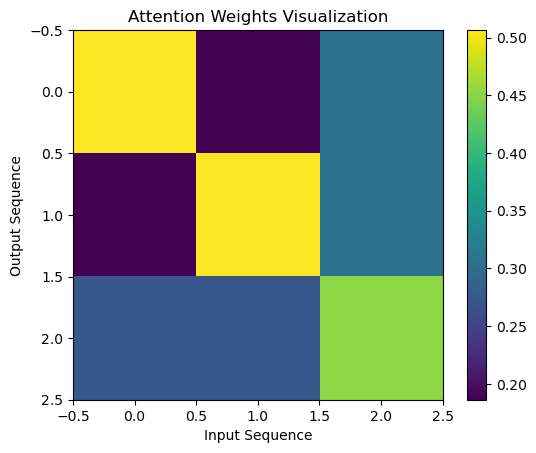

Output from Multi-Head Attention:
 tensor([[[ 0.1367, -0.2819,  0.0927,  0.4478],
         [-0.1354, -0.4186, -0.5878,  0.6200],
         [-0.2719, -0.4759, -0.4203,  0.1670]]], grad_fn=<ViewBackward0>)


In [5]:
""" 
Tutorial: Understanding of Attention Mechanisms in Transformers
GitHub: https://github.com/PKSR-DS/Attention-Mechanisms-in-Transformers 
Student Name: Praveen Kumar Savariraj 
Student ID: 23089117

"""

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Function to compute self-attention
def compute_self_attention(queries, keys, values):
    """
    This function calculates the self-attention output and the corresponding attention weights.
    
    Parameters:
    queries: Tensor representing the queries
    keys: Tensor representing the keys
    values: Tensor representing the values
    
    Returns:
    output: The resulting attention output
    attention_weights: The weights assigned to each input
    """
    # Calculate the attention scores using the scaled dot-product method
    scores = torch.matmul(queries, keys.T) / np.sqrt(keys.size(-1))
    
    # Apply softmax to convert scores into attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Compute the output as a weighted sum of the values
    output = torch.matmul(attention_weights, values)
    return output, attention_weights

# Create a sample input tensor representing three words with four-dimensional embeddings
sample_input = torch.tensor([[1, 0, 1, 0],
                              [0, 1, 0, 1],
                              [1, 1, 0, 0]], dtype=torch.float32)

# For simplicity, we will use the same input for queries, keys, and values
queries = keys = values = sample_input

# Calculate the self-attention output and weights
output, attention_weights = compute_self_attention(queries, keys, values)
print("Attention Output:\n", output)
print("Attention Weights:\n", attention_weights)

# Function to visualize the attention weights
def display_attention_weights(weights):
    """
    Visualizes the attention weights using a heatmap.
    
    Parameters:
    weights: The attention weights to visualize
    """
    plt.imshow(weights.detach().numpy(), cmap='viridis')
    plt.colorbar()
    plt.title('Attention Weights Visualization')
    plt.xlabel('Input Sequence')
    plt.ylabel('Output Sequence')
    plt.show()

# Visualize the attention weights
display_attention_weights(attention_weights)

# Class definition for Multi-Head Attention
class MultiHeadAttentionLayer(torch.nn.Module):
    def __init__(self, embedding_size, num_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.head_dim = embedding_size // num_heads

        # Ensure the embedding size is divisible by the number of heads
        assert (self.head_dim * num_heads == embedding_size), "Embedding size must be divisible by number of heads"

        # Linear layers for values, keys, and queries
        self.values_layer = torch.nn.Linear(embedding_size, embedding_size, bias=False)
        self.keys_layer = torch.nn.Linear(embedding_size, embedding_size, bias=False)
        self.queries_layer = torch.nn.Linear(embedding_size, embedding_size, bias=False)
        self.output_layer = torch.nn.Linear(embedding_size, embedding_size)

    def forward(self, x):
        """
        Forward pass for the multi-head attention layer.
        
        Parameters:
        x: Input tensor of shape (batch_size, seq_length, embedding_size)
        
        Returns:
        output: The output of the multi-head attention layer
        """
        batch_size = x.shape[0]
        seq_length = x.shape[1]

        # Transform the input into multiple heads
        values = self.values_layer(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        keys = self.keys_layer(x).view(batch_size, seq_length, self.num_heads, self.head_dim)
        queries = self.queries_layer(x).view(batch_size, seq_length, self.num_heads, self.head_dim)

        # Rearrange dimensions for multi-head attention
        values = values.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, head_dim)
        keys = keys.permute(0, 2, 1, 3)      # (batch_size, num_heads, seq_length, head_dim)
        queries = queries.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_length, head_dim)

        # Calculate attention scores
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])  # (batch_size, num_heads, query_length, key_length)
        attention_scores = F.softmax(energy / (self.embedding_size ** (1 / 2)), dim=3)

        # Compute the output using the attention scores
        out = torch.einsum("nhql,nlhd->nqhd", [attention_scores, values]).reshape(batch_size, seq_length, self.num_heads * self.head_dim)
        return self.output_layer(out)

# Example usage of the Multi-Head Attention class
if __name__ == "__main__":
    embedding_size = 4  # Size of the embedding
    num_heads = 2       # Number of attention heads
    multi_head_attention_layer = MultiHeadAttentionLayer(embedding_size, num_heads)

    # Perform a forward pass with the sample input
    output_multihead = multi_head_attention_layer(sample_input.unsqueeze(0))  # Add batch dimension
    print("Output from Multi-Head Attention:\n", output_multihead)